In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model_ev_updated.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   tile_centroid_lat            12479 non-null  float64
 6   tile_centroid_lon            12479 non-null  float64
 7   district_number              12479 non-null  int64  
 8   year                         12479 non-null  int64  
 9   Unemployment_Rate            12479 non-null  float64
 10  Average_Age                  12479 non-null  float64
 11  Elderly_Population           12479 non-null  float64
 12  Young_Population             12479 non-null  float64
 13  Total_Population

In [4]:
df['panel_area_log'] = np.log1p(df['panel_area_m2'])


In [24]:
feature_cols = [
    'year',
    'total_rooftops',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    'tile_encoded',
        "employed",
        "pv_price",
        # 'panel_area_lag1',
        # 'ev_points_164m'
]

# Drop rows with missing lag values
df_model = df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [25]:
# Sort by time (CRITICAL)
df_model = df_model.sort_values("year")

# Define years
test_year = df_model["year"].max()
val_year  = df_model[df_model["year"] < test_year]["year"].max()

# Split dataframe
train_df = df_model[df_model["year"] < val_year]
val_df   = df_model[df_model["year"] == val_year]
test_df  = df_model[df_model["year"] == test_year]

# Features and target
X_train = train_df[feature_cols]
y_train = train_df["panel_area_log"]

X_val   = val_df[feature_cols]
y_val   = val_df["panel_area_log"]

X_test  = test_df[feature_cols]
y_test  = test_df["panel_area_log"]

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  r2_score, root_mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict
y_pred = model.predict(X_test)

# R2 score
print("R2 score:", r2_score(y_test, y_pred))

# RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)



R2 score: 0.774166912024026
RMSE: 1.0849615148783012


In [20]:
import joblib

# Save the model
joblib.dump(model, "random_forest_model_ev.joblib")

['random_forest_model_ev.joblib']

In [16]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)          # inverse of log1p
y_test_real = np.expm1(y_test.values)  # convert back to original scale


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [100, 300, 500,700],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}


In [8]:
# Predict (log-transformed target if you trained on log1p)
y_pred_log = best_model.predict(X_test)

# If your target was log-transformed during training
y_pred = np.expm1(y_pred_log)


NameError: name 'best_model' is not defined

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error

# If y_test was also log-transformed
y_test_real = np.expm1(y_test.values)

r2 = r2_score(y_test_real, y_pred)
mae = mean_absolute_error(y_test_real, y_pred)

print(f"R²: {r2:.3f}, MAE: {mae:.3f}")


R²: 0.665, MAE: 161.294


In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize features (PCA requires normalized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Print variance explained by each component
print("Variance explained by each component:")
print(pca_full.explained_variance_ratio_)
print(f"\nCumulative variance explained: {np.cumsum(pca_full.explained_variance_ratio_)}")


Variance explained by each component:
[0.38963783 0.17858694 0.14255738 0.11496982 0.10018715 0.04820191
 0.02299786 0.00226975 0.00059138]

Cumulative variance explained: [0.38963783 0.56822476 0.71078214 0.82575196 0.92593911 0.97414101
 0.99713887 0.99940862 1.        ]


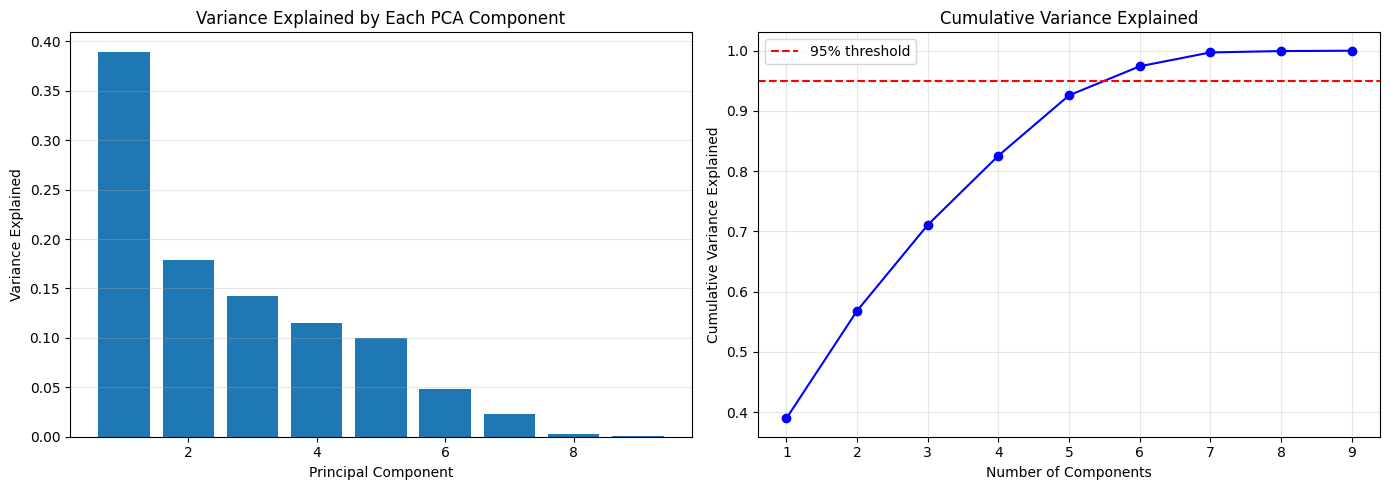


Components needed for 95% variance: 6


In [44]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance explained by each component
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance Explained by Each PCA Component')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Cumulative variance explained
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")


In [45]:
# Apply PCA with reduced components (e.g., 95% variance)
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features via PCA: {X_train_pca.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%")


Original features: 9
Reduced features via PCA: 6
Dimensionality reduction: 33.3%



Feature loadings on principal components:
                         PC1       PC2       PC3       PC4       PC5       PC6
total_rooftops      0.018320  0.214688 -0.378381 -0.583204  0.630216  0.264499
Unemployment_Rate  -0.212794  0.512988  0.426527 -0.099742  0.157352 -0.488161
Average_Age         0.248520  0.446059 -0.300541 -0.123133 -0.566644  0.221886
Elderly_Population  0.498412  0.060934  0.220853 -0.135547 -0.127231  0.178823
Young_Population    0.477738 -0.064901  0.256229 -0.000405  0.277431 -0.213403
Total_Population    0.453038 -0.133853  0.401777 -0.141701  0.056738  0.190615
tile_encoded        0.217712  0.089802 -0.242347  0.735937  0.394122  0.164847
employed           -0.356415 -0.394980  0.330943 -0.091924  0.011843  0.497241
pv_price           -0.190524  0.549426  0.374792  0.215074  0.071665  0.504212


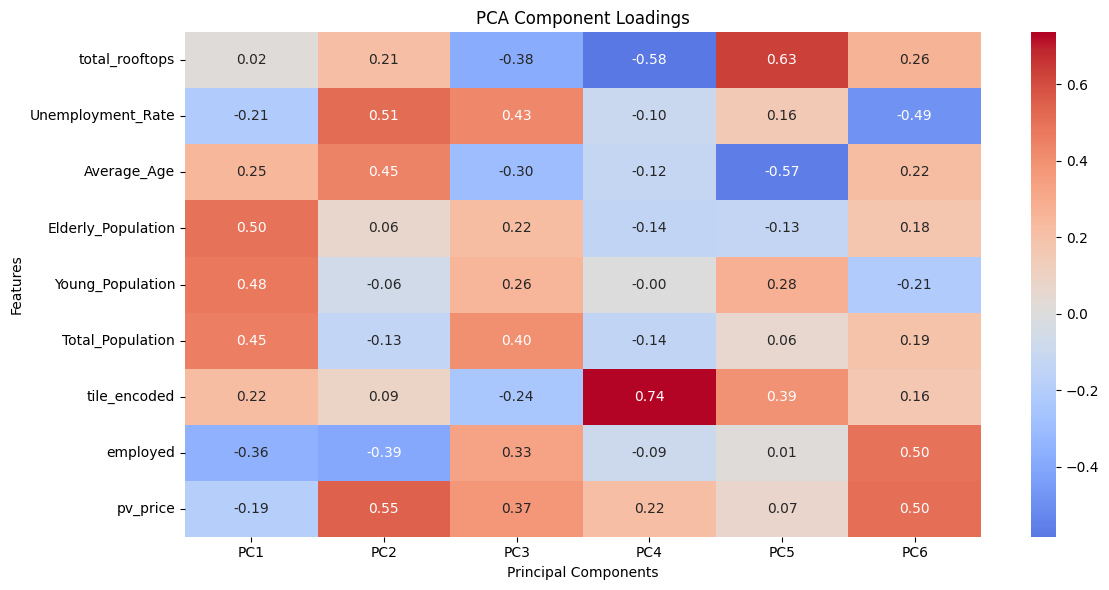

In [46]:
# Feature contributions to PCA components
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_cols
)

print("\nFeature loadings on principal components:")
print(components_df)

# Visualize component loadings
plt.figure(figsize=(12, 6))
sns.heatmap(components_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('PCA Component Loadings')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()


In [47]:
# Train model with PCA features
model_pca = RandomForestRegressor(n_estimators=100, random_state=42)
model_pca.fit(X_train_pca, y_train)

# Predict with PCA features
y_pred_pca = model_pca.predict(X_test_pca)

# Compare performance
print("=" * 50)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 50)
print("\nOriginal Features:")
print(f"  R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"  RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

print("\nPCA Features (reduced dimensions):")
print(f"  R2 Score: {r2_score(y_test, y_pred_pca):.4f}")
print(f"  RMSE: {root_mean_squared_error(y_test, y_pred_pca):.4f}")

print("\nDimensionality Reduction Summary:")
print(f"  Original features: {X_train.shape[1]}")
print(f"  PCA components: {n_components_95}")
print(f"  Reduction: {(1 - n_components_95/X_train.shape[1])*100:.1f}%")


MODEL PERFORMANCE COMPARISON

Original Features:
  R2 Score: -14854.3575
  RMSE: 278.2673

PCA Features (reduced dimensions):
  R2 Score: 0.4334
  RMSE: 1.7185

Dimensionality Reduction Summary:
  Original features: 9
  PCA components: 6
  Reduction: 33.3%


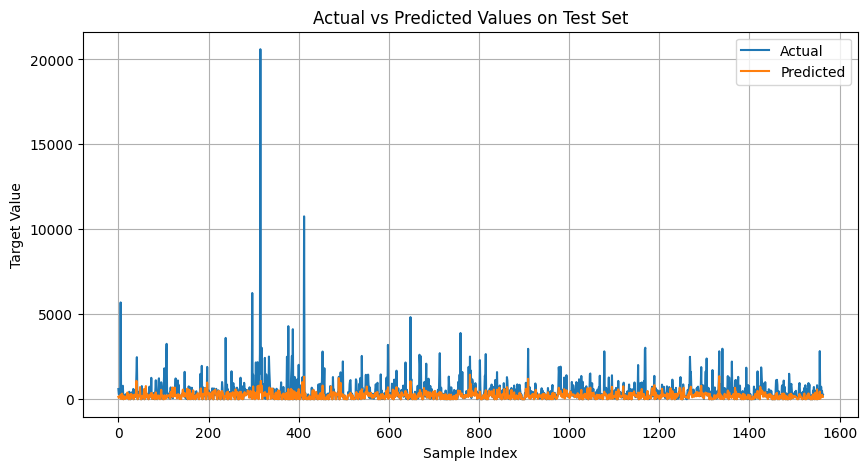

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Actual")   # Add markers to see points clearly
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import shap
explainer = shap.TreeExplainer(model)
X_shap = X_val.copy()

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Compute SHAP values (if not done yet)
shap_values = explainer.shap_values(X_shap)

# 2️⃣ Optional: sample rows if X_shap is large
if X_shap.shape[0] > 500:  # adjust threshold as needed
    sample_idx = np.random.choice(X_shap.shape[0], 500, replace=False)
    X_plot = X_shap.iloc[sample_idx] if hasattr(X_shap, 'iloc') else X_shap[sample_idx]
    shap_values_plot = shap_values[sample_idx] if isinstance(shap_values, np.ndarray) else [v[sample_idx] for v in shap_values]
else:
    X_plot = X_shap
    shap_values_plot = shap_values

# 3️⃣ Plot summary (faster bar plot)
shap.summary_plot(shap_values_plot, X_plot, plot_type='bar', max_display=15)



In [13]:
# Requires scikit-garden (pip install scikit-garden)
from skgarden import RandomForestQuantileRegressor

# Train and save Quantile Random Forest models for prediction intervals
quantile_targets = {'10': 0.1, '90': 0.9}
quantile_models = {}

for label, tau in quantile_targets.items():
    qrf = RandomForestQuantileRegressor(
        n_estimators=500,
        random_state=42,
        min_samples_leaf=5,
        quantile=tau
)
    qrf.fit(X_train, y_train)
    quantile_models[label] = qrf
    joblib.dump(qrf, f"random_forest_quantile_{label}.joblib")
    print(f"✓ Trained and saved RandomForestQuantileRegressor for τ={tau}")

# Quick sanity check on the test split (values are back-transformed)
for label, qrf in quantile_models.items():
    y_q_log = qrf.predict(X_test)
    y_q = np.expm1(y_q_log)
    print(f"{label}th percentile prediction (test mean): {y_q.mean():,.2f} m²")

ModuleNotFoundError: No module named 'skgarden'

In [12]:
!pip install scikit-garden

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 4.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [163 lines of output]
      /tmp/pip-install-7cfaboc5/scikit-garden_df34acaecc754145ac7e286a037affd3/setup.py:7: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.core import setup
      /home/elsherif/Desktop/Thesis/ViewPython/.venvGeometry/lib/python3.10/site-packages/setuptools/dist.py:723: UserWarning: Usage of dash